# Training the model for text recognation

In [ ]:
!pip install keras_ocr

     |████████████████████████████████| 57 kB 2.2 MB/s 
     |████████████████████████████████| 9.5 MB 7.4 MB/s 
     |████████████████████████████████| 870 kB 33.0 MB/s 
     |████████████████████████████████| 123 kB 51.7 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.7-py3-none-any.whl size=43748 sha256=1488c637f71abdf41cf4de0ad9cbbfc48cb6294aac677ccff3f5def0fb5b89a6
  Stored in directory: /root/.cache/pip/wheels/e4/e4/f3/05528293e01d7fa089343d5a5fd63dd07d79f57103fe9fc159
Successfully built keras-ocr


In [ ]:
import zipfile
import datetime
import string
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.config.list_physical_devices('GPU'), 'No GPU is available.'

data_dir = '.'
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for ./fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|██████████| 2746/2746 [00:26<00:00, 102.04it/s]


Looking for ./backgrounds.zip


The first generated text is: Field medals methane neon nitrogen nitric oxide phosphine silane sulfuric acid.
The first generated validation image (below) contains: Mxi
co in in p
osting


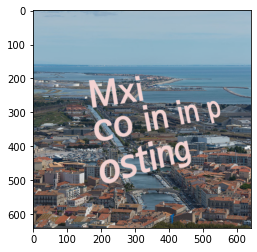

In [ ]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size),
    batch_size=detector_batch_size
)

/usr/local/lib/python3.7/dist-packages/keras_ocr/tools.py:504: RuntimeWarning: invalid value encountered in float_scalars
  rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))


Epoch 1/1000
827/827 [==============================] - 816s 944ms/step - loss: 0.0080 - val_loss: 0.0138
Epoch 2/1000
827/827 [==============================] - 780s 944ms/step - loss: 0.0054 - val_loss: 0.0088
Epoch 3/1000
827/827 [==============================] - 786s 950ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 4/1000
827/827 [==============================] - 785s 949ms/step - loss: 0.0056 - val_loss: 0.0305
Epoch 5/1000
827/827 [==============================] - 785s 949ms/step - loss: 0.0050 - val_loss: 0.0080
Epoch 6/1000
827/827 [==============================] - 782s 946ms/step - loss: 0.0041 - val_loss: 0.0152
Epoch 7/1000
827/827 [==============================] - 771s 932ms/step - loss: 0.0050 - val_loss: 0.0317
Epoch 8/1000
827/827 [==============================] - 780s 943ms/step - loss: 0.0037 - val_loss: 0.0071


This image contains: Pl


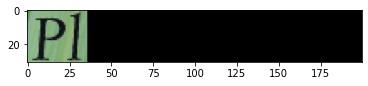

In [ ]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
    image_generator=image_generator,
    batch_size=recognition_batch_size,
    lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=1000,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0,
    bacth_size=recognition_batch_size
)

TypeError: ignored

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions]
)
plt.imshow(drawn)

In [ ]:
recognizer.model.save_weights(f'{recognizer_basepath}.h5')

# Manipulating the quality of detection